In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed

In [2]:
!pip install xgboost

In [2]:
df=pd.read_csv('../data/unusual_drop_preprocess_all_v4.csv')

In [3]:
df.head()

,acc_now_delinq,acc_open_past_24mths,addr_state,annual_inc,bc_open_to_buy,bc_util,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_2yrs,dti,...,total_rev_hi_lim,verification_status,emp_length,fico,credit_hist_months,have_bc,have_rev,treasury,funded_amnt,irr
0,0.0,8.0,OK,11.608245,8.702178,70.374384,0,0,1,34.70,...,10.317483,Verified,10+ years,672.0,278,1,1,0.000889,23200.0,-0.028885
1,0.0,5.0,TX,11.082158,10.919099,6.566836,0,0,0,17.74,...,11.157707,Not Verified,unknown,822.0,401,1,1,0.001392,16000.0,-0.016852
2,0.0,3.0,FL,10.819798,7.815207,73.376344,0,0,0,6.99,...,9.532569,Not Verified,5 years,702.0,226,1,1,0.001228,4500.0,0.008687
3,0.0,6.0,IL,11.002117,6.891626,91.072727,0,0,0,28.94,...,10.229260,Source Verified,10+ years,677.0,190,1,1,0.000841,20000.0,0.008325
4,0.0,5.0,NC,11.487854,9.901736,69.192901,0,0,0,10.31,...,11.302229,Verified,5 years,737.0,206,1,1,0.001805,19000.0,-0.087127


In [6]:
# 'int_rate'를 연 이자율 퍼센트 단위 -> 월 이자율, 소수 단위로 바꾸기
df['int_rate'] = (1 + df['int_rate']/100) ** (1/12) - 1

In [7]:
df['int_rate'].head()

0    0.018762
1    0.005709
2    0.008294
3    0.007967
4    0.013867
Name: int_rate, dtype: float64

In [ ]:
with open('../data/selected_cols_v1.txt', 'r', encoding='utf-8') as f:
    selected_cols_v1 = [line.strip() for line in f if line.strip()]

In [ ]:
with open('../data/categorical_cols_v1.txt', 'r', encoding='utf-8') as f:
    cat_columns_v1 = [line.strip() for line in f if line.strip() != '']

In [10]:
# 모델에 넣는 변수들 이외 필요한 변수들 확인
df_else = df.drop(selected_cols_v1, axis=1)
df_else = df_else.drop(cat_columns_v1, axis=1)
df_else.head()

,id,installment,int_rate,issue_d,loan_amnt,loan_status,loan_status_label,sub_grade,total_pymnt,treasury,funded_amnt,irr
0,84253847,680.82,0.018762,2016-07-01,23200.0,1,연체/부실,E4,8599.680000,0.000889,23200.0,-0.028885
1,119708428,494.55,0.005709,2017-10-01,16000.0,1,연체/부실,A2,11804.280000,0.001392,16000.0,-0.016852
2,109906493,146.10,0.008294,2017-05-01,4500.0,0,정상상환,B3,5134.174383,0.001228,4500.0,0.008687
3,60286250,645.25,0.007967,2015-09-01,20000.0,0,정상상환,B3,23278.037543,0.000841,20000.0,0.008325
4,151871973,482.17,0.013867,2019-05-01,19000.0,1,연체/부실,D1,444.230000,0.001805,19000.0,-0.087127


In [11]:
df_sel = df[selected_cols_v1]

In [12]:
df_cat = df[cat_columns_v1]
df_cat.head()

,addr_state,inq_last_6mths,emp_length,home_ownership,purpose,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_rcnt_il,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,verification_status,grade
0,OK,1,10+ years,MORTGAGE,debt_consolidation,<1yr,unknown,unknown,<1yr,<1yr,<1yr,0,<1yr,Verified,E
1,TX,0,unknown,MORTGAGE,home_improvement,unknown,unknown,unknown,1-2yr,<1yr,unknown,10+,unknown,Not Verified,A
2,FL,0,5 years,MORTGAGE,home_improvement,unknown,unknown,<3yr,2yr+,1-2yr,unknown,6,unknown,Not Verified,B
3,IL,0,10+ years,MORTGAGE,credit_card,3-4yr,4-5yr,unknown,unknown,1-2yr,3-4yr,5,3-4yr,Source Verified,B
4,NC,1,5 years,MORTGAGE,debt_consolidation,unknown,unknown,unknown,1-2yr,1-2yr,unknown,6,unknown,Verified,D


In [13]:
# 범주형 변수들 -> 원핫인코딩
# columns=cat_columns_v1 (리스트 그대로 전달)
df_cat = pd.get_dummies(df_cat, columns = cat_columns_v1, drop_first=True)

In [14]:
df_cat.head()

,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,...,mths_since_recent_revol_delinq_<1yr,mths_since_recent_revol_delinq_unknown,verification_status_Source Verified,verification_status_Verified,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
0,False,False,False,False,False,False,False,False,False,False,...,True,False,False,True,False,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,True,False,...,False,True,False,False,True,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,True,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,True,False,True,False,False,True,False,False,False


In [15]:
# 연속형 변수와 원핫인코딩 합치기
df_model = pd.concat([df_sel, df_cat], axis=1)

In [16]:
obj_cols = df_model.select_dtypes(include='object').columns
print(obj_cols)

Index([], dtype='object')


In [17]:
print(list(df_model.columns))

['mo_sin_old_rev_tl_op', 'open_acc', 'num_tl_30dpd', 'mo_sin_rcnt_tl', 'acc_open_past_24mths', 'mort_acc', 'collections_12_mths_ex_med', 'tot_hi_cred_lim', 'total_rev_hi_lim', 'num_rev_accts', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_old_il_acct', 'num_accts_ever_120_pd', 'revol_bal', 'num_actv_rev_tl', 'term', 'num_bc_tl', 'acc_now_delinq', 'dti', 'fico', 'num_actv_bc_tl', 'pct_tl_nvr_dlq', 'num_il_tl', 'bc_open_to_buy', 'pub_rec', 'bc_util', 'revol_util', 'num_bc_sats', 'delinq_2yrs', 'total_bal_ex_mort', 'total_acc', 'num_tl_op_past_12m', 'have_bc', 'credit_hist_months', 'have_rev', 'tot_coll_amt', 'annual_inc', 'pub_rec_bankruptcies', 'num_op_rev_tl', 'num_tl_120dpd_2m', 'tax_liens', 'chargeoff_within_12_mths', 'num_tl_90g_dpd_24m', 'addr_state_AL', 'addr_state_AR', 'addr_state_AZ', 'addr_state_CA', 'addr_state_CO', 'addr_state_CT', 'addr_state_DC', 'addr_state_DE', 'addr_state_FL', 'addr_state_GA', 'addr_state_HI', 'addr_state_IA', 'addr_state_ID', 'addr_state_IL', 'addr_state_IN', 'addr_

In [18]:
# 모델2의 목적함수는 'irr' 예측하기
X = df_model
meta = df_else[['funded_amnt', 'treasury', 'irr']] # 스케일링 되지 않은 값이 필요
y = df_else['irr']

In [19]:
# 3대 1로 train set, validation set 나누기
X_tr,X_val,y_tr,y_val, meta_tr, meta_val = train_test_split(
    X,y, meta, test_size=0.25, random_state=111
)

In [20]:
# 1. 컬럼명 클린업 함수 정의
def clean_feature_names(df):
    df.columns = (
        df.columns
        .astype(str)
        .str.replace('[', '(', regex=False)
        .str.replace(']', ')', regex=False)
        .str.replace('<', 'lt', regex=False)
        .str.replace('>', 'gt', regex=False)
    )
    return df

# 2. 적용
X_tr = clean_feature_names(X_tr)
X_val = clean_feature_names(X_val)  # validation set도 동일


In [21]:
# XGBoost 회귀 모델 학습
xgb = XGBRegressor(
    n_estimators=200,  # 트리 개수(적당히 조정)
    max_depth=5,       # 트리 깊이(데이터 상황에 따라)
    learning_rate=0.1, # 러닝레이트
    random_state= 111,
    n_jobs=-1
)
xgb.fit(X_tr, y_tr)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=-1, num_parallel_tree=None, ...)

In [22]:
importances = xgb.feature_importances_
importance_df = pd.DataFrame({
    'feature': X_tr.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(importance_df.head(15))

                        feature  importance
144  mths_since_rcnt_il_unknown    0.076559
105          emp_length_unknown    0.030145
108         home_ownership_RENT    0.025717
5                      mort_acc    0.024615
15                         term    0.023775
4          acc_open_past_24mths    0.018925
102          emp_length_8 years    0.016821
155     mths_since_recent_inq_1    0.012601
52                addr_state_GA    0.012017
94             inq_last_6mths_2    0.011763
95         emp_length_10+ years    0.011230
174                     grade_B    0.010670
146   mths_since_recent_bc_3yr+    0.010527
17               acc_now_delinq    0.010359
101          emp_length_7 years    0.010001


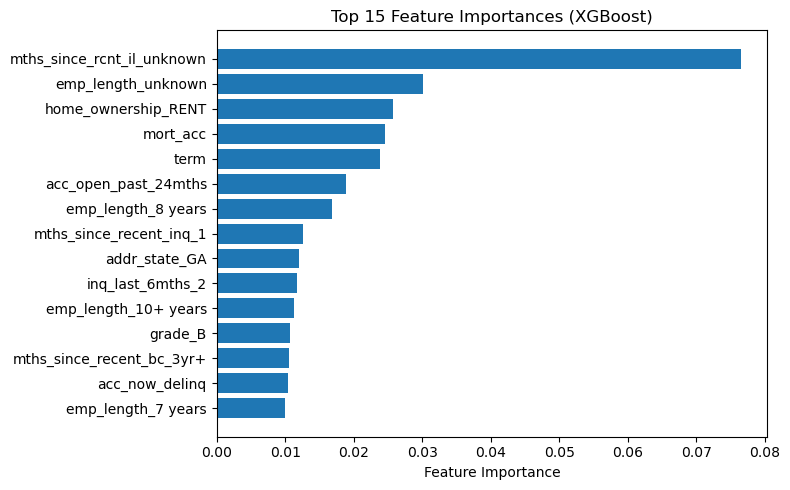

In [23]:
plt.figure(figsize=(8,5))
plt.barh(importance_df['feature'][:15], importance_df['importance'][:15])
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances (XGBoost)')
plt.tight_layout()
plt.show()

In [24]:
# 모델 불러오고, fit하고 예측하는 순서대로 진행됨
y_val_pred = xgb.predict(X_val)

# 1. min-max scaling
y_val_pred_min_max = (y_val_pred - y_val_pred.min()) / (y_val_pred.max() - y_val_pred.min())

# 2. 좌우반전 (이후 sharpe ratio 구할 때 맞춰주기 위함)
y_val_pred = 1 - y_val_pred_min_max

(array([2.10000e+01, 8.46000e+02, 3.80690e+04, 1.08516e+05, 7.67060e+04,
        3.06220e+04, 9.96600e+03, 2.84900e+03, 8.29000e+02, 2.16000e+02,
        9.50000e+01, 3.90000e+01, 1.70000e+01, 1.30000e+01, 8.00000e+00,
        7.00000e+00, 6.00000e+00, 1.00000e+00, 4.00000e+00, 1.00000e+00,
        0.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00, 2.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([0.        , 0.03333334, 0.06666667, 0.1       , 0.13333334,
        0.16666667, 0.2       , 0.23333333, 0.26666668, 0.30000001,
        0.33333334, 0.36666667, 0.40000001, 0.43333334, 0.46666667,
        0.5       , 0.53333336, 0.56666666, 0.60000002, 0.63333333,
        0.66666669, 0.69999999, 0.73333335, 0.76666665, 0.80000001,
        0.83333331, 0.86666667, 0.89999998, 0.93333334, 0.96666664,
        1.        ]),
 <BarContainer object of 30 artists>)

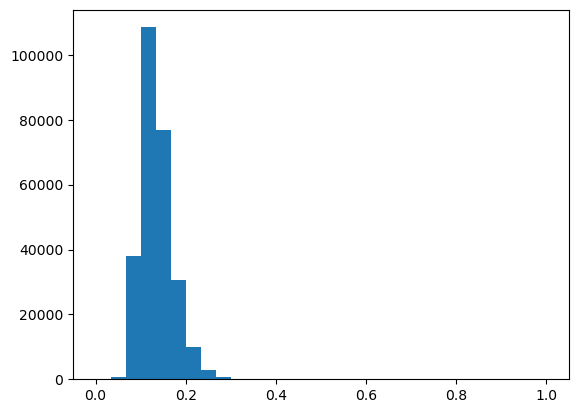

In [25]:
# 좌우반전 y_val_pred 분포
plt.hist(y_val_pred, bins=30)

In [ ]:
thresholds, sharpe_ratios = [], []

# meta_val에 'irr', 'treasury' 컬럼이 반드시 포함되어 있어야 함!
for t in np.linspace(0.01, 0.99, 100):
    # 회귀 예측값을 threshold 이상이면 1(=> 대출 안 해줌), 아니면 0(=> 대출해줌)으로 간주
    val_binary = (y_val_pred > t).astype(int)
    val_return = []
    for pred, actual, irr, treasury in zip(val_binary, y_val, meta_val['irr'], meta_val['treasury']):
        if pred == 0:
            val_return.append(irr)
        else:
            val_return.append(treasury)
    val_return = np.array(val_return)
    risk_free = np.array(meta_val.['treasury'])
    excess_ret = val_return - risk_free
    if excess_ret.std() > 0:
        sharpe = excess_ret.mean() / excess_ret.std()
    else:
        sharpe = np.nan
    thresholds.append(t)
    sharpe_ratios.append(sharpe)

thresholds = np.array(thresholds)
sharpe_ratios = np.array(sharpe_ratios)

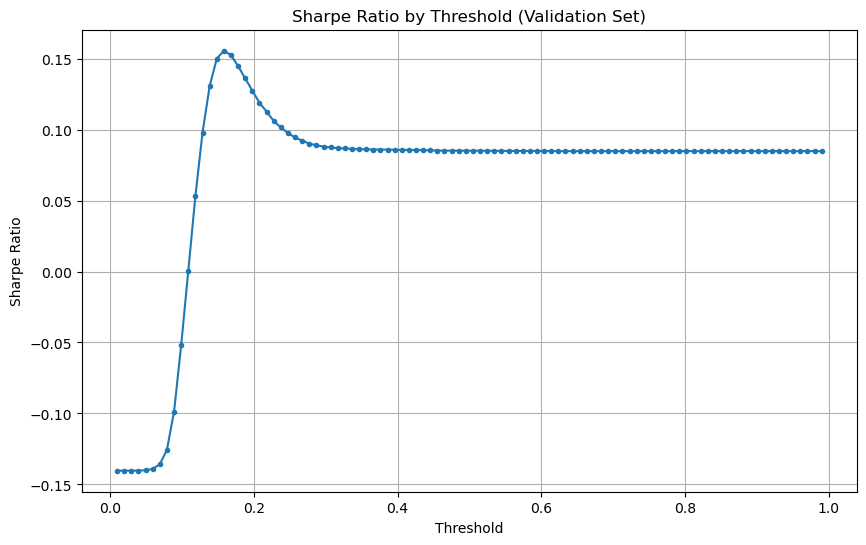

 Optimal Threshold: 0.158
 Max Sharpe Ratio: 0.1555


In [27]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, sharpe_ratios, marker='o', markersize=3)
plt.xlabel("Threshold")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio by Threshold (Validation Set)")
plt.grid(True)
plt.show()

optimal_idx = np.nanargmax(sharpe_ratios)
optimal_threshold = thresholds[optimal_idx]
print(f" Optimal Threshold: {optimal_threshold:.3f}")
print(f" Max Sharpe Ratio: {sharpe_ratios[optimal_idx]:.4f}")


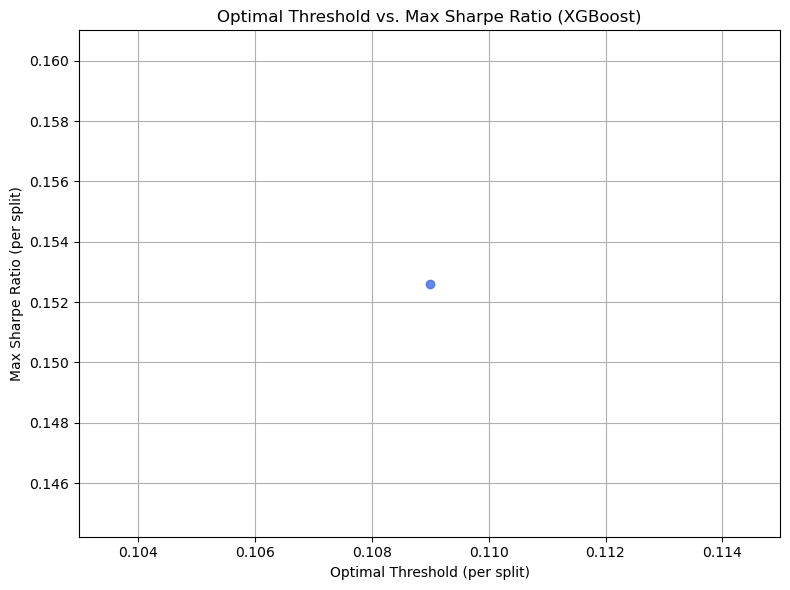

==== Sharpe Ratio Stats ====
평균 Sharpe Ratio      : 0.1526
최대 Sharpe Ratio      : 0.1526
최소 Sharpe Ratio      : 0.1526
중앙값 Sharpe Ratio    : 0.1526
표준편차 Sharpe Ratio  : 0.0000

==== Threshold Stats ====
평균 Threshold         : 0.1090
최대 Threshold         : 0.1090
최소 Threshold         : 0.1090
중앙값 Threshold       : 0.1090
표준편차 Threshold     : 0.0000


In [29]:
from joblib import Parallel, delayed

N_BOOTSTRAP = 1

def calc_max_sharpe_xgb(seed):
    X_tr, X_val, y_tr, y_val, meta_tr, meta_val = train_test_split(
        X, y, meta, test_size=0.25, random_state=seed
    )
    X_tr = X_tr.copy()
    X_val = X_val.copy()
    meta_tr = meta_tr.reset_index(drop=True)
    meta_val = meta_val.reset_index(drop=True)
    y_val = y_val.reset_index(drop=True)

    # 변수명에 특수문제 안 들어가게 통제
    X_tr = clean_feature_names(X_tr)
    X_val = clean_feature_names(X_val)  # validation set도 동일

    # XGBoost 회귀 모델 학습
    xgb = XGBRegressor(
        n_estimators=200,  # 트리 개수(적당히 조정)
        max_depth=5,       # 트리 깊이(데이터 상황에 따라)
        learning_rate=0.1, # 러닝레이트
        random_state=seed,
        n_jobs=-1
    )
    xgb.fit(X_tr, y_tr)
    y_val_pred = xgb.predict(X_val)

    # 1. min-max scaling
    y_val_pred_min_max = (y_val_pred - y_val_pred.min()) / (y_val_pred.max() - y_val_pred.min())
    # 2. 좌우대칭(Sharpe 계산을 위한 방향 맞춤)
    y_val_pred = 1 - y_val_pred_min_max

    thresholds, sharpe_ratios = [], []
    for t in np.linspace(0.01, 0.99, 100):
        val_binary = (y_val_pred > t).astype(int)
        val_return = []
        for pred, actual, irr, treasury in zip(val_binary, y_val, meta_val['irr'], meta_val['treasury']):
            if pred == 0:
                val_return.append(irr)
            else:
                val_return.append(treasury - irr)
        val_return = np.array(val_return)
        risk_free = np.array(meta_val['treasury'])
        excess_ret = val_return - risk_free
        if excess_ret.std() > 0:
            sharpe = excess_ret.mean() / excess_ret.std()
        else:
            sharpe = np.nan
        thresholds.append(t)
        sharpe_ratios.append(sharpe)

    sharpe_ratios = np.array(sharpe_ratios)
    thresholds = np.array(thresholds)
    max_sharpe = np.nanmax(sharpe_ratios)
    optimal_threshold = thresholds[np.nanargmax(sharpe_ratios)]
    return max_sharpe, optimal_threshold

sharpe_dist_xgb = Parallel(n_jobs=-1)(
    delayed(calc_max_sharpe_xgb)(seed) for seed in range(N_BOOTSTRAP)
)

# 부트스트랩 결과 분리
max_sharpes = np.array([v[0] for v in sharpe_dist_xgb])
opt_thresholds = np.array([v[1] for v in sharpe_dist_xgb])

# 1. 산점도 (threshold vs sharpe ratio)
plt.figure(figsize=(8,6))
plt.scatter(opt_thresholds, max_sharpes, alpha=0.8, color='royalblue')
plt.xlabel("Optimal Threshold (per split)")
plt.ylabel("Max Sharpe Ratio (per split)")
plt.title("Optimal Threshold vs. Max Sharpe Ratio (XGBoost)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. 통계량 출력
print("==== Sharpe Ratio Stats ====")
print(f"평균 Sharpe Ratio      : {np.nanmean(max_sharpes):.4f}")
print(f"최대 Sharpe Ratio      : {np.nanmax(max_sharpes):.4f}")
print(f"최소 Sharpe Ratio      : {np.nanmin(max_sharpes):.4f}")
print(f"중앙값 Sharpe Ratio    : {np.nanmedian(max_sharpes):.4f}")
print(f"표준편차 Sharpe Ratio  : {np.nanstd(max_sharpes):.4f}")

print("\n==== Threshold Stats ====")
print(f"평균 Threshold         : {np.nanmean(opt_thresholds):.4f}")
print(f"최대 Threshold         : {np.nanmax(opt_thresholds):.4f}")
print(f"최소 Threshold         : {np.nanmin(opt_thresholds):.4f}")
print(f"중앙값 Threshold       : {np.nanmedian(opt_thresholds):.4f}")
print(f"표준편차 Threshold     : {np.nanstd(opt_thresholds):.4f}")


In [31]:
# 1. 컬럼명 클린업 함수 정의
def clean_feature_names(df):
    df.columns = (
        df.columns
        .astype(str)
        .str.replace('[', '(', regex=False)
        .str.replace(']', ')', regex=False)
        .str.replace('<', 'lt', regex=False)
        .str.replace('>', 'gt', regex=False)
    )
    return df

# 2. 적용
X_total = clean_feature_names(X)

In [32]:
# 최종모델
xgb_final = XGBRegressor(
    n_estimators=200,  # 트리 개수(적당히 조정)
    max_depth=5,       # 트리 깊이(데이터 상황에 따라)
    learning_rate=0.1, # 러닝레이트
    random_state= 111,
    n_jobs=-1
)
xgb_final.fit(X_total, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=-1, num_parallel_tree=None, ...)

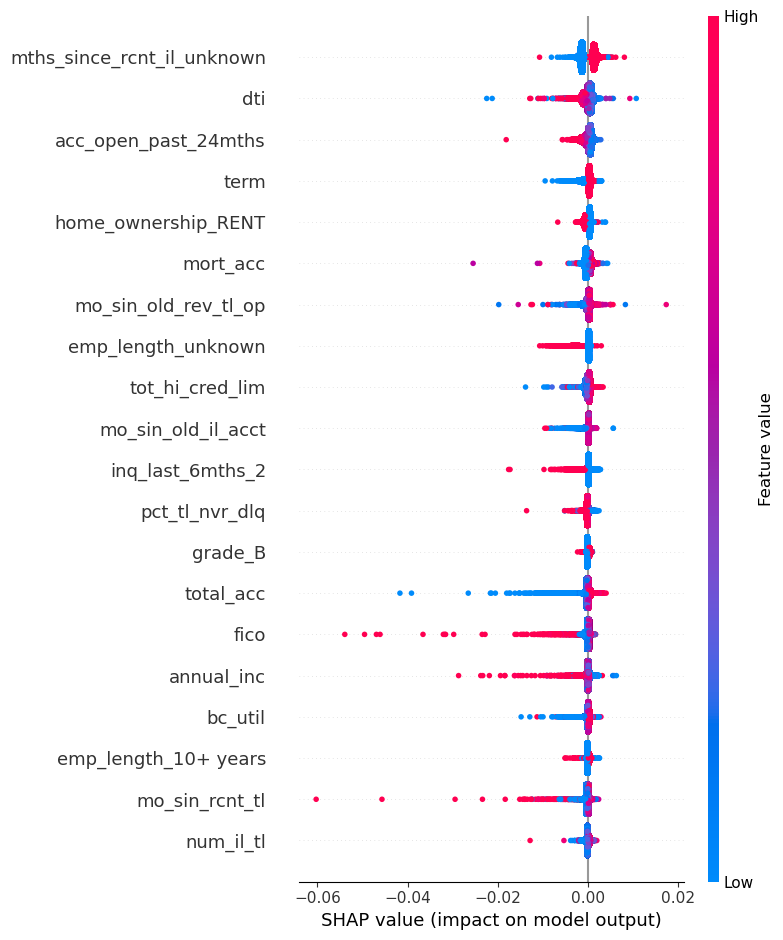

In [34]:
# X에 있는 독립변수들은 각각 irr 예측값에 얼마나 영향력이 있는가?
# 'irr 예측값'에 대한 영향력임을 유의!!
# shap는 모델의 독립변수-종속변수에 대한 Shapley value를 지원할 뿐,
# 지금의 경우는 sharpe ratio가 

import shap

# 1. explainer 객체 생성 (트리계열은 TreeExplainer 사용)
explainer = shap.Explainer(xgb_final)  # model은 xgb, rf, cbr 등 이미 학습된 모델

# 2. shap 값 계산
shap_values = explainer(X_total)

# 3. 요약 시각화 (변수별 shapley value의 분포)
shap.summary_plot(shap_values, X_total, plot_type='dot', show=True)
